### 1)  Import the nececary packets and tools

In [2]:
import numpy as np
from numpy import genfromtxt

import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf
import Utools as utls #modified AnaTools
import Ptools4Jup as ptls
 
#plt.ion()  #interactive mode on
%matplotlib inline


In this tutorial you will train our vanilla (default) net - some times we refer to it as Igor's net.

### 2) Load the test data set

In [3]:
# Set the path pointing to the data files:
path = '/Users/Yuquan/Documents/SLAC/tutorial/'

In [4]:
%%time

# Read the .dat file and drop the header:
test_data = utls.readBoolMike(path + 'data/test/e1chRNWFs_19.dat')
#data_train = utls.readBoolMike(path + 'data/train/e1chRNWFs_2.dat')


# Seperate the waveforms and the labels:
x_test,y_test = utls.sepXY(test_data)

# Make a baseline correction:
#x_test = utls.baseCorrection(test_data)

# Store the data in a DataSet object:
data_test = utls.DataSet(x_test,y_test)

print("success")

success
CPU times: user 17.1 s, sys: 1.24 s, total: 18.4 s
Wall time: 18.8 s


Now you can plot a waveform to see how it looks:

size of set: 14973
Samlpe Number: 8705
True energy [keV]: 0.0


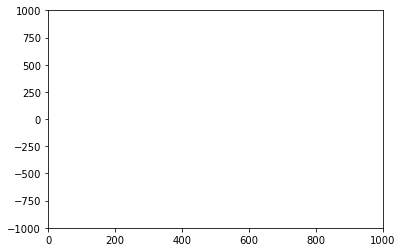

In [5]:
sizeOfSet = data_test.images.shape[0]

sample = np.random.randint(sizeOfSet)

axes = plt.gca()
axes.set_xlim([0,1000])
axes.set_ylim([-1000,1000])
print ("size of set: " + str(sizeOfSet))
print ("Samlpe Number: " + str(sample))
print ("True energy [keV]: " + str(y_test[sample,0]))
fig = plt.plot(x_test[sample])

Plot of th eenergy spectrum of the data set:

Loading train date: file 0
14982
CPU times: user 17.8 s, sys: 1.23 s, total: 19.1 s
Wall time: 19.4 s


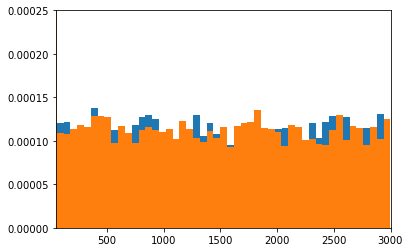

In [6]:
%%time
plt.hist(y_test, 50, normed=1)
plt.axis([50, 3000, 0, 0.00025])
plt.show;


#load train_data



nFiles = 1

train_data = np.empty((0,1001),np.float32)

for i in range(nFiles):
    print("Loading train date: file {0}".format(i))
    train_temp = utls.readBoolMike(path + 'data/train/e1chRNWFs_'+str(i)+'.dat')
    train_data = np.append(train_data,train_temp,axis=0)

x_train,y_train = utls.sepXY(train_data)
#x_train = utls.baseCorrection(x_train)
data_train = utls.DataSet(x_train,y_train)
#print ("size of set: " + str(train_test.images.shape[0]))

sizeOfSet = data_train.images.shape[0]

print (sizeOfSet)
plt.hist(y_train, 50, normed=1)
plt.axis([50, 3000, 0, 0.00025])
plt.show;

### 3) Load the train data set.

This may take a while! In total there are 19 files. Here we only load 3 but you can simply change the number to 19.

### 4) Load the architecture of the network.

'x' is the input waveform, 'y_' the predicted label, and 'y' the ture label. The network has 7 layers - An input layer, an output layer, and 5 hidden layers. The layers are similar. They gradualy reduce the neurons from 1000 (x) to 1 (y_). All layers have a ReLu activation function. The input layer has in addition a dropout option.

In [7]:
x = tf.placeholder(tf.float32,[None,1000])
#tf.placeholder(dtype, shape=None, name=None)
# 1000个array  构成1*1000matirx
#print("success")
y_ = tf.placeholder(tf.float32,[None,1])
#tf.placeholder(dtype, shape=None, name=None)
#print("success")
# Input layer
W0 = tf.get_variable("W0",shape=[1000,500],initializer=tf.contrib.layers.xavier_initializer())
#tf.get_variable(name, shape=None, dtype=None, 
#initializer=None, regularizer=None, trainable=True, collections=None, caching_device=None, 
#partitioner=None, validate_shape=True, custom_getter=None)

#print("success")


#set a matrix  1000*500  basically1000个500大小的array
b0 = utls.bias_var([500])
h0 = tf.nn.relu(tf.matmul(x,W0)+b0)
#     tf.nn.relu(features, name=None)


keep_prob = tf.placeholder(tf.float32)
#tf.placeholder(dtype, shape=None, name=None)
h0_drop = tf.nn.dropout(h0,keep_prob)
#tf.nn.dropout(x, keep_prob, noise_shape=None, seed=None, name=None)
##each element has same posibilty to drop
#print("sucess")
# Hidden layer 1
W1 = tf.get_variable("W1",shape=[500,200],initializer=tf.contrib.layers.xavier_initializer())
b1 = utls.bias_var([200])
# i guess matrix 200*200
h1 = tf.nn.relu(tf.matmul(h0_drop,W1)+b1)
#print("success")

# Hidden layer 2
W2 = tf.get_variable("W2",shape=[200,100],initializer=tf.contrib.layers.xavier_initializer())
b2 = utls.bias_var([100])
h2 = tf.nn.relu(tf.matmul(h1,W2)+b2)
#print("success")
# Hidden layer 3
W3 = tf.get_variable("W3",shape=[100,40],initializer=tf.contrib.layers.xavier_initializer())
b3 = utls.bias_var([40])
h3 = tf.nn.relu(tf.matmul(h2,W3)+b3)

# Hidden layer 4
W4 = tf.get_variable("W4",shape=[40,10],initializer=tf.contrib.layers.xavier_initializer())
b4 = utls.bias_var([10])
h4 = tf.nn.relu(tf.matmul(h3,W4)+b4)

# Hidden layer 5
W5 = tf.get_variable("W5",shape=[10,2],initializer=tf.contrib.layers.xavier_initializer())
b5 = utls.bias_var([2])
h5 = tf.nn.relu(tf.matmul(h4,W5)+b5)

# Output layer
W_last = tf.get_variable("W_last",shape=[2,1],initializer=tf.contrib.layers.xavier_initializer())
b_last = utls.bias_var([1])
y = tf.nn.relu(tf.matmul(h5,W_last)+b_last)



### 5) Define the Mean Squar Error (MSE), the regularization, and loss.

In [8]:
mse = tf.reduce_mean(tf.square(y-y_))
#tf.reduce_mean(input_tensor, axis=None, keep_dims=False, name=None, reduction_indices=None)

regularizers = (tf.nn.l2_loss(W0)+tf.nn.l2_loss(b0)+tf.nn.l2_loss(W1)+tf.nn.l2_loss(b1)+
tf.nn.l2_loss(W2)+tf.nn.l2_loss(b2)+tf.nn.l2_loss(W3)+tf.nn.l2_loss(b3)+
tf.nn.l2_loss(W4)+tf.nn.l2_loss(b4)+tf.nn.l2_loss(W5)+tf.nn.l2_loss(b5)+
tf.nn.l2_loss(W_last)+tf.nn.l2_loss(b_last))

# dimention problems how to clculate loss with 2 more dimentions

loss = mse + regularizers*1.e-4

print(loss)
print (type(loss))

Tensor("add_20:0", shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.Tensor'>


### 6) Define optimizer

In [9]:
# the optimizer itself:
opt = tf.train.AdamOptimizer()

# the vanilla operation trains the whole network
opt_operation = opt.minimize(loss)
#优化

# this allows to train a layer individualy
opt_operation_0 = opt.minimize(loss, var_list=[W0,b0])
opt_operation_1 = opt.minimize(loss, var_list=[W1,b1])
opt_operation_2 = opt.minimize(loss, var_list=[W2,b2])
opt_operation_3 = opt.minimize(loss, var_list=[W3,b3])
opt_operation_4 = opt.minimize(loss, var_list=[W4,b4])
opt_operation_5 = opt.minimize(loss, var_list=[W5,b5])
opt_operation_last = opt.minimize(loss, var_list=[W_last,b_last])

### 7) Define a saver which allows to save and restore checkpoints of the trained newtork

In [10]:
saver = tf.train.Saver()

### 8) Initialize all the weights of the network

Either, random initialization of the weights..

In [11]:
# start a TensorFlow session:
with tf.Session() as sess:
    
    # random initialization:
    sess.run(tf.global_variables_initializer())
    
    # save the weights in a file
    save_path = saver.save(sess, path + "check-points/start.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: /Users/Yuquan/Documents/SLAC/tutorial/check-points/start.ckpt


... or a bit more sofisticated. (Some random initializated networks will not learn!)

In [12]:
# start a TensorFlow session:
with tf.Session() as sess:
    Q_good_start = 0
    
    # this loop selects a reasonable starting point and saves it in "start.ckpt"
    while Q_good_start == 0:
        sess.run(tf.global_variables_initializer())
        save_path = saver.save(sess, path + "check-points/start.ckpt")
        
        # this loop takes the random initialization and trains the net for 100 steps to see if it learns.
         #batch[0],batch[1] = data_train.next_batch(500)
        for i in range(100):
            batch = data_train.next_batch(500)
            sess.run([opt_operation],feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})
        
        # test if the net learned
        tce = mse.eval(feed_dict={x:data_test.images,y_:data_test.labels,keep_prob:1.0},session=sess)
        print("test mse %g"%(tce))
            
        if tce < 500000:
            Q_good_start = 1
            print("Yay! Start saved in file: %s" % save_path)

test mse 992407
test mse 742917
test mse 992407
test mse 992365
test mse 992407
test mse 992407
test mse 992407
test mse 992349
test mse 992209
test mse 992407
test mse 992407
test mse 992210
test mse 992407
test mse 992407
test mse 743504
test mse 992407
test mse 744946
test mse 992217
test mse 992407
test mse 765676
test mse 748506
test mse 992211
test mse 992224
test mse 992220
test mse 745001
test mse 992407
test mse 992407
test mse 992407
test mse 992210
test mse 992407
test mse 992407
test mse 992208
test mse 741411
test mse 992407
test mse 992407
test mse 992209
test mse 755722
test mse 744256
test mse 992212
test mse 740966
test mse 992407
test mse 743883
test mse 992220
test mse 744937
test mse 992407
test mse 744649
test mse 992220
test mse 768893
test mse 992407
test mse 992407
test mse 992407
test mse 746996
test mse 743119
test mse 743822
test mse 742434
test mse 992209
test mse 992216
test mse 744706
test mse 992407
test mse 992407
test mse 744652
test mse 744782
test mse

KeyboardInterrupt: 

### 9) Training the network!

The first training cycle! The time used to execute this cell is measured using the magic function %%time. Note the difference in used CPU time between this cell and the next cell. Can you see why?

In [ ]:
%%time

# define how to train this training cycle
batchSize = 500
trainSteps = 5000

# start a TensorFlow session:
with tf.Session() as sess:
    
    # restore the network's weights
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,path + "check-points/start.ckpt")
    
    # the train cycle
    for i in range(trainSteps):
        # grap a train batch
        batch = data_train.next_batch(batchSize)
        
        # run the optimizier - train the net!
        sess.run([opt_operation],feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})
        
        # every now and then save the weights and print some stuff
        if i%1000 == 0:
            save_path = saver.save(sess, path + "check-points/temp.ckpt")
            print("step %d"%(i))
    
    # end this train cycle
    print("Train cycle 1 ended with a test accuracy of: {0}".format("%.2f" % mse.eval(feed_dict={x:data_test.images,y_:data_test.labels,keep_prob:1.})))
    save_path = saver.save(sess, path + "check-points/cycle1-end.ckpt")

... or you can add some plots to the training. This helps to see what happend during training.

In [ ]:
%%time

sizeOfSet = data_train.images.shape[0]
train_time = []
i=0
trainloss = []
testloss = []
cycleID = 1

# define how to train this training cycle
batchSize = 500
trainSteps = 5000

# start a TensorFlow session:
with tf.Session() as sess:
    
    # restore the network's weights
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,path + "check-points/start.ckpt")
    
    # the train cycle
    for j in xrange(trainSteps):
        # grap a train batch
        batch = data_train.next_batch(batchSize)
        
        # run the optimizier - train the net!
        sess.run([opt_operation],feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})
        
        # count how many samples were used to train
        i += batchSize
        
        # every now and then save the weights and print some stuff
        if j%100 == 0:
            save_path = saver.save(sess, path + "check-points/temp.ckpt")
            
            train_mse = mse.eval(feed_dict={x:data_train.images,y_:data_train.labels,keep_prob:1.0},session=sess)
            trainloss.append(train_mse)
            test_mse = mse.eval(feed_dict={x:data_test.images,y_:data_test.labels,keep_prob:1.0},session=sess)
            testloss.append(test_mse)
            train_time.append(float(i)/sizeOfSet)

            if j%1000 == 0:
                # ploting output:
                ptls.PrintInfo(j,test_mse)
                print("success")
        
    # end this train cycle
    print("Train cycle 1 ended with a test accuracy of: {0}".format("%.2f" % mse.eval(feed_dict={x:data_test.images,y_:data_test.labels,keep_prob:1.})))
    save_path = saver.save(sess, path + "check-points/cycle1-end.ckpt")
    
    # learning rate plot
    ptls.MSEHist(cycleID,trainloss,testloss,train_time)

The subsequent training cycles: (BUT don't do this as it may take very long!)

In [ ]:
# define how to train this training cycle
batchSize = 1000
trainSteps = 1000
opt = tf.train.AdamOptimizer(1.0e-4)

# start a TensorFlow session:
with tf.Session() as sess:
    
    # restore the network's weights
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,path + "check-points/cycle1-end.ckpt")
    
    # the train cycle
    for i in xrange(trainSteps):
        # grap a train batch
        batch = data_train.next_batch(batchSize)
        
        # run the optimizier - train the net!
        sess.run([opt_operation],feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})
        
        # every now and then save the weights and print some stuff
        if i%100 == 0:
            save_path = saver.save(sess, "temp.ckpt")
            print("step %d"%(i))
    
    # end this train cycle
    print("Train cycle 2 ended with a test accuracy of: {0}".format("%.2f" % mse.eval(feed_dict={x:data_test.images,y_:data_test.labels,keep_prob:1.})))
    save_path = saver.save(sess, "cycle2-end.ckpt")

In [ ]:
# define how to train this training cycle
batchSize = 5000
trainSteps = 10000
opt = tf.train.AdamOptimizer(1.0e-5)

# start a TensorFlow session:
with tf.Session() as sess:
    
    # restore the network's weights
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,path + "cycle2-end.ckpt")
    
    # the train cycle
    for i in xrange(trainSteps):
        # grap a train batch
        batch = data_train.next_batch(batchSize)
        
        # run the optimizier - train the net!
        sess.run([opt_operation],feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})
        
        # every now and then save the weights and print some stuff
        if i%1000 == 0:
            save_path = saver.save(sess, path + "check-points/temp.ckpt")
            print("step %d"%(i))
    
    # end this train cycle
    print("Train cycle 3 ended with a test accuracy of: {0}".format("%.2f" % mse.eval(feed_dict={x:data_test.images,y_:data_test.labels,keep_prob:1.})))
    save_path = saver.save(sess, path + "check-points/cycle3-end.ckpt")

In [ ]:
# define how to train this training cycle
batchSize = 15000
trainSteps = 100000
opt = tf.train.AdamOptimizer(1.0e-6)

# start a TensorFlow session:
with tf.Session() as sess:
    
    # restore the network's weights
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,path + path + "check-points/cycle3-end.ckpt")
    
    # the train cycle
    for i in xrange(trainSteps):
        # grap a train batch
        batch = data_train.next_batch(batchSize)
        
        # run the optimizier - train the net!
        sess.run([opt_operation],feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})
        
        # every now and then save the weights and print some stuff
        if i%1000 == 0:
            save_path = saver.save(sess, path + "check-points/temp.ckpt")
            print("step %d"%(i))
    
    # end this train cycle
    print("Train cycle 4 ended with a test accuracy of: {0}".format("%.2f" % mse.eval(feed_dict={x:data_test.images,y_:data_test.labels,keep_prob:1.})))
    save_path = saver.save(sess, path + "check-points/cycle4-end.ckpt")